# 1. Topic Attention pipeline

In [1]:
!pip install wordcloud

In [2]:
from wordcloud import WordCloud

class Topic:
    def __init__(self, cluster):
        self.cluster = cluster
        self.sentences = []
        self.sentences_dump = ""
        self.words = []
        self.wordcloud = WordCloud()
        self.texts = []
        self.sorted_terms = []
        self.coherence = 0.0
        
class TopicModel:
    def __init__(self):
        self.sentences = []
        self.vocabulary = []     
        self.topics = []
        self.topics_coherence = 0.0
        
model = TopicModel()

## Step 1: Sentences Modeling

In [39]:
import os.path

# DATASET = 'clicr'
DATASET = 'MovieLens'

# DATASET_PATH = '../datasets/'+DATASET+'/cases-titles.txt'
DATASET_PATH = '../datasets/'+DATASET+'/ml-latest-small/movies.csv'

BERT_MODEL = 'bert-base-cased'
# BERT_MODEL = 'dmis-lab/biobert-base-cased-v1.1'
# BERT_MODEL = 'HeroGeonil/Hypert-medical'
# BERT_MODEL = 'fagner/hypernym'
# BERT_MODEL = 'fagner/envoy'
# BERT_MODEL = 'bert-sts'

OUTPUT_PATH = 'output/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += DATASET + '/'
if not os.path.exists(OUTPUT_PATH): os.mkdir(OUTPUT_PATH)
OUTPUT_PATH += BERT_MODEL + '/'
if not os.path.exists(OUTPUT_PATH): os.makedirs(OUTPUT_PATH, exist_ok=True)

In [40]:
# re.split(r'\s+\((\d+)\)', model.sentences[0])

In [41]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import re

# arquivo = 'ml-latest-small/movies.csv'
df = pd.read_csv(DATASET_PATH) 

# with open(DATASET_PATH) as f:
model.sentences = df['title']+ '[SEP]' +df['genres']

for i in range(len(model.sentences)):
    s1 = re.split(r'\s+\((\d+)\)', model.sentences[i])
    if len(s1)==3:
        model.sentences[i] = s1[0] + s1[2]
print(model.sentences)
# re.split(r'\s+\((\d+)\)', model.sentences)[0]

# model.sentences = model.sentences.split(' (')
# with open(DATASET_PATH) as f:
#     model.sentences = f.readlines()
    
# language_model = SentenceTransformer("/home/jovyan/models/"+BERT_MODEL)
language_model = SentenceTransformer(BERT_MODEL)
embeddings = language_model.encode(model.sentences)

0       Toy Story[SEP]Adventure|Animation|Children|Com...
1                  Jumanji[SEP]Adventure|Children|Fantasy
2                     Grumpier Old Men[SEP]Comedy|Romance
3              Waiting to Exhale[SEP]Comedy|Drama|Romance
4                  Father of the Bride Part II[SEP]Comedy
                              ...                        
9737    Black Butler: Book of the Atlantic[SEP]Action|...
9738    No Game No Life: Zero[SEP]Animation|Comedy|Fan...
9739                                      Flint[SEP]Drama
9740    Bungo Stray Dogs: Dead Apple[SEP]Action|Animation
9741              Andrew Dice Clay: Dice Rules[SEP]Comedy
Length: 9742, dtype: object


No sentence-transformers model found with name sentence-transformers/bert-sts. Creating a new one with MEAN pooling.


OSError: sentence-transformers/bert-sts is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
# language_model.state_dict()['encoder.layer.0.attention.self.query.weight']
# language_model.state_dict()['0.auto_model.embeddings.word_embeddings.weight'].encode(model.sentences)

In [ ]:
# from sentence_transformers import SentenceTransformer

# with open(DATASET_PATH) as f:
#     model.sentences = f.readlines()
# language_model = SentenceTransformer("/home/jovyan/models/"+BERT_MODEL)
# embeddings = language_model.encode(model.sentences)

In [ ]:
# model.sentences

In [ ]:
from matplotlib import pyplot as plt 
from sklearn import manifold

X_2d = manifold.SpectralEmbedding(n_components=2).fit_transform(embeddings)
 
x = X_2d[:,0]
y = X_2d[:,1]

plt.clf()
plt.figure(figsize=(5, 4))
plt.scatter(x, y, color='black', s=3)
plt.savefig(OUTPUT_PATH + 'sentence-embeddings-'+str(BERT_MODEL).replace('/','').replace('.','') + '.eps', bbox_inches='tight', format='png')

## Step 2: Sentences Aggregation

In [ ]:
DISTANCE_THRESHOLD = 150

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(linkage='ward', distance_threshold=DISTANCE_THRESHOLD, n_clusters=None)
clustering_model = clustering_model.fit(embeddings)
n_clusters = clustering_model.n_clusters_

print('Distance Threshold: ', DISTANCE_THRESHOLD)
print('Resulting Clusters:',  n_clusters)

In [ ]:
plt.clf()
plt.figure(figsize=(5, 4))

plt.scatter(x, y, color='w', s=1)

for i, sentence in enumerate(model.sentences):
    plt.annotate(clustering_model.labels_[i], (x[i], y[i]), color=plt.cm.nipy_spectral(clustering_model.labels_[i] / 10.), fontsize=20)
    
if not os.path.exists(OUTPUT_PATH + str(n_clusters) + 'topics'): os.mkdir(OUTPUT_PATH + str(n_clusters) + 'topics')

plt.axis("off")
plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/clusters-'+str(BERT_MODEL).replace('/','').replace('.','') + '.eps', bbox_inches='tight', format='eps')

### Topics Hierarchy

In [ ]:
from scipy.cluster.hierarchy import dendrogram
import numpy as np

plt.clf()
plt.figure(figsize=(7,5))

counts = np.zeros(clustering_model.children_.shape[0])
n_samples = len(clustering_model.labels_)

for i, merge in enumerate(clustering_model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else: current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([clustering_model.children_, clustering_model.distances_, counts]).astype(float)

r = dendrogram(linkage_matrix, truncate_mode='lastp', p=n_clusters, color_threshold=0, above_threshold_color='black')
plt.axhline(c='black', linestyle='--', y=DISTANCE_THRESHOLD) 

plt.savefig(OUTPUT_PATH + 'dendrograma-'+str(BERT_MODEL).replace('/','').replace('.','')+'.eps', bbox_inches='tight')

## Step 3: Representing Topics

In [ ]:
MAX_DF = 0.99
TOP_WORDS = 10

In [ ]:
# pip install nltk

In [ ]:
# pd.DataFrame(c_tfidf.todense(), columns=tfidf_model.vocabulary_)
# tfidf_data_frame

In [ ]:
pip install stop_words

In [ ]:
model.sentences

In [42]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.feature_extraction import text 

# # stop_words = text.ENGLISH_STOP_WORDS.union('SEP Adventure Animation Children Comedy Fantasy Romance Drama Action Crime Thriller Horror Mystery Sci-Fi War Musical Documentary IMAX Western Film-Noir (no genres listed)'.split())
# stop_words = text.ENGLISH_STOP_WORDS.union(['SEP', 'Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance',
# 'Drama','Action','Crime','Thriller','Horror','Mystery','Sci-Fi','War','Musical','Documentary','IMAX','Western',
# 'Film-Noir', '(no genres listed)'])

# stop = 'SEP Adventure Animation Children Comedy Fantasy Romance Drama Action Crime Thriller Horror Mystery Sci-Fi War Musical Documentary IMAX Western Film-Noir (no genres listed)'

model.topics = [Topic(i) for i in range(n_clusters)]
for i in range(len(model.sentences)):
    cluster_index = clustering_model.labels_[i]
    # print(model.sentences[i])
    model.topics[cluster_index].sentences.append(re.split('[SEP]', model.sentences[i])[0])
    model.topics[cluster_index].sentences_dump += re.split('[SEP]', model.sentences[i])[0] + " "

# tfidf_model = TfidfVectorizer(max_df=MAX_DF)
# tfidf_model = TfidfVectorizer(max_df=MAX_DF)
tfidf_model = TfidfVectorizer(stop_words='english')

c_tfidf = tfidf_model.fit_transform([topic.sentences_dump for topic in model.topics])
tfidf_matrix = c_tfidf.toarray()

terms = tfidf_model.get_feature_names_out()
# print(terms)
model.vocabulary = terms

terms_by_topic = tfidf_model.inverse_transform(c_tfidf)
        
for i, topic in enumerate(model.topics):
    sorted_term_indexes = np.argsort(-1*tfidf_matrix[topic.cluster])
    topic.sorted_terms = [terms[j] for j in sorted_term_indexes]   
    
    topic.words = terms_by_topic[i]

    dense = c_tfidf[topic.cluster].todense()
    lst1 = dense.tolist()
    tfidf_data_frame = pd.DataFrame(lst1, columns=terms)
    # print(tfidf_data_frame.T.sum(axis=1))
    topic.wordcloud = WordCloud(mode='RGBA', background_color="white", max_words=TOP_WORDS, color_func=lambda *args, **kwargs: "black").generate_from_frequencies(tfidf_data_frame.T.sum(axis=1))

<Figure size 640x480 with 0 Axes>

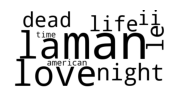

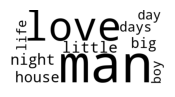

In [43]:
from matplotlib import pyplot as plt 

plt.clf()

for topic in model.topics:
    plt.figure(figsize=(2, 2))

    plt.imshow(topic.wordcloud)
    plt.axis("off")

    if not os.path.exists(OUTPUT_PATH + str(n_clusters) + 'topics'): os.mkdir(OUTPUT_PATH + str(n_clusters) + 'topics')

    plt.savefig(OUTPUT_PATH + str(n_clusters) + 'topics/wordcloud'+str(topic.cluster)+'.jpg', transparent=True, bbox_inches='tight')

# 2. Validation

In [44]:
pip install gensim 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [45]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

dictionary = Dictionary(terms_by_topic)
corpus = [dictionary.doc2bow(t) for t in terms_by_topic]
texts = [[dictionary[word_id] for word_id, freq in c] for c in corpus]

cm = CoherenceModel(topics=[topic.words for topic in model.topics], texts=texts, corpus=corpus, dictionary=dictionary, coherence='c_v',topn=TOP_WORDS)

model.topics_coherence = cm.get_coherence()
model.coherence_per_topic = cm.get_coherence_per_topic()

for i, coherence in enumerate(model.coherence_per_topic):
    model.topics[i].coherence = coherence

print('Total coherence: ', model.topics_coherence)
print('Coherence by topic: ', model.coherence_per_topic)    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Total coherence:  0.5834032140377985
Coherence by topic:  [0.6840737590368476, 0.48273266903874923]


In [46]:
with open(OUTPUT_PATH + '/topic-attention-results.txt', "a") as file:
    print('Hyper-parameters: ', file=file) 
    print('Language Model: ' + BERT_MODEL + '\t Distance Threshold: '+str(DISTANCE_THRESHOLD) + '\t Resulting Topics: '+str(n_clusters) + '\t TfIdf Threshold: '+str(MAX_DF) + '\t Top Words: '+str(TOP_WORDS), file=file)   
    print("", file=file)
    for topic in model.topics:
        print('Topic '+str(topic.cluster), file=file)    
        print('Documents length: '+str(len(topic.sentences)), file=file)
        print('Terms length: '+str(len(topic.words)), file=file)

        print('Coherence: '+str(topic.coherence), file=file)
        print('Top Words: '+str(topic.sorted_terms[:10]), file=file)  
        print('', file=file)

    print('Total Coherence: '+str(model.topics_coherence), file=file)  
    print('Total Terms considered: '+str(len(model.vocabulary)), file=file)
    print('----------------------------------------------------------------------------', file=file)  